In [22]:
"""
A series of helper functions used throughout the course.

If a function gets defined once and could be used over and over, it'll go in here.
"""
import torch
import matplotlib.pyplot as plt
import numpy as np

from torch import nn

import os
import zipfile

from pathlib import Path

import requests

# Walk through an image classification directory and find out how many files (images)
# are in each subdirectory.
import os

def walk_through_dir(dir_path):
    """
    Walks through dir_path returning its contents.
    Args:
    dir_path (str): target directory

    Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


# Plot linear data or training and test and predictions (optional)
def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    """
  Plots linear training data and test data and compares predictions.
  """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})


# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


def print_train_time(start, end, device=None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"\nTrain time on {device}: {total_time:.3f} seconds")
    return total_time


# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()


# # Pred and plot image function from notebook 04
# # See creation: https://www.learnpytorch.io/04_pytorch_custom_datasets/#113-putting-custom-image-prediction-together-building-a-function
# from typing import List
# import torchvision


# def pred_and_plot_image(
#     model: torch.nn.Module,
#     image_path: str,
#     class_names: List[str] = None,
#     transform=None,
#     device: torch.device = "cuda" if torch.cuda.is_available() else "cpu",
# ):
#     """Makes a prediction on a target image with a trained model and plots the image.

#     Args:
#         model (torch.nn.Module): trained PyTorch image classification model.
#         image_path (str): filepath to target image.
#         class_names (List[str], optional): different class names for target image. Defaults to None.
#         transform (_type_, optional): transform of target image. Defaults to None.
#         device (torch.device, optional): target device to compute on. Defaults to "cuda" if torch.cuda.is_available() else "cpu".
    
#     Returns:
#         Matplotlib plot of target image and model prediction as title.

#     Example usage:
#         pred_and_plot_image(model=model,
#                             image="some_image.jpeg",
#                             class_names=["class_1", "class_2", "class_3"],
#                             transform=torchvision.transforms.ToTensor(),
#                             device=device)
#     """

#     # 1. Load in image and convert the tensor values to float32
#     target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

#     # 2. Divide the image pixel values by 255 to get them between [0, 1]
#     target_image = target_image / 255.0

#     # 3. Transform if necessary
#     if transform:
#         target_image = transform(target_image)

#     # 4. Make sure the model is on the target device
#     model.to(device)

#     # 5. Turn on model evaluation mode and inference mode
#     model.eval()
#     with torch.inference_mode():
#         # Add an extra dimension to the image
#         target_image = target_image.unsqueeze(dim=0)

#         # Make a prediction on image with an extra dimension and send it to the target device
#         target_image_pred = model(target_image.to(device))

#     # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
#     target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

#     # 7. Convert prediction probabilities -> prediction labels
#     target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

#     # 8. Plot the image alongside the prediction and prediction probability
#     plt.imshow(
#         target_image.squeeze().permute(1, 2, 0)
#     )  # make sure it's the right size for matplotlib
#     if class_names:
#         title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
#     else:
#         title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
#     plt.title(title)
#     plt.axis(False)

def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

def download_data(source: str, 
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.
    
    Returns:
        pathlib.Path to downloaded data.
    
    Example usage:
        download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                      destination="pizza_steak_sushi")
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it... 
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)
        
        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...") 
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)
    
    return image_path


### Make classification data and get it ready

In [1]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples, noise = 0.03, random_state=42)

In [2]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


In [3]:
# Turn data into tensors
# Otherwise this causes issues with computations later on
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [4]:
import pandas as pd

circles = pd.DataFrame({"X1": X[:, 0], "X2": X[:,1], "label": y})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1.0
1,-0.756159,0.153259,1.0
2,-0.815392,0.173282,1.0
3,-0.393731,0.692883,1.0
4,0.442208,-0.896723,0.0


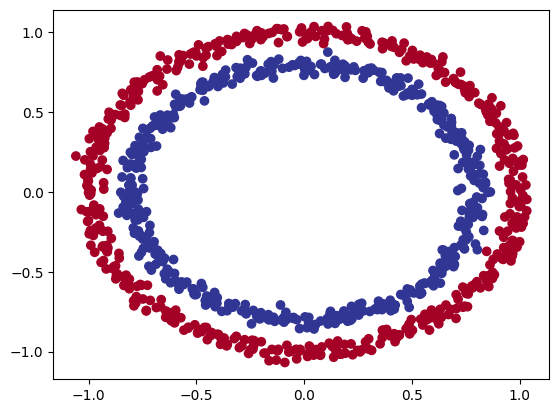

In [5]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu);

In [6]:
X.shape, y.shape

(torch.Size([1000, 2]), torch.Size([1000]))

In [7]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: tensor([0.7542, 0.2315]) and the same for y: 1.0
Shapes for one sample of X: torch.Size([2]) and the same for y: torch.Size([])


In [8]:
# Standard PyTorch imports
import torch
from torch import nn

# Make device agnostic code
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [9]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [10]:
# 1. Construct a model class that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features (X), produces 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features, produces 1 feature (y)
    
    # 3. Define a forward method containing the forward pass computation
    def forward(self, x):
        # Return the output of layer_2, a single feature, the same shape as y
        return self.layer_2(self.layer_1(x)) # computation goes through layer_1 first then the output of layer_1 goes through layer_2

# 4. Create an instance of the model and send it to target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [11]:
# Replicate CircleModelV0 with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [12]:
# View the frist 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.5026],
        [0.3968],
        [0.6402],
        [0.4641],
        [0.4187]], device='mps:0', grad_fn=<SliceBackward0>)

In [13]:
# Make predictions with the model
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[0.5026],
        [0.3968],
        [0.6402],
        [0.4641],
        [0.4187],
        [0.3558],
        [0.2337],
        [0.2235],
        [0.6493],
        [0.3873]], device='mps:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [14]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), 
                            lr=0.1)

# View the frist 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
y_logits
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='mps:0')


tensor([1., 1., 1., 1., 1.], device='mps:0', grad_fn=<SqueezeBackward0>)

In [15]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='mps:0')


tensor([1., 1., 1., 1., 1.], device='mps:0', grad_fn=<SqueezeBackward0>)

In [18]:
y_test[:5]
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [19]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls
  
    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train) 
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train) 
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred) 

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.72324, Accuracy: 50.00% | Test loss: 0.71538, Test acc: 50.00%
Epoch: 10 | Loss: 0.70615, Accuracy: 50.00% | Test loss: 0.70088, Test acc: 50.00%
Epoch: 20 | Loss: 0.70001, Accuracy: 56.12% | Test loss: 0.69607, Test acc: 57.00%
Epoch: 30 | Loss: 0.69742, Accuracy: 51.62% | Test loss: 0.69440, Test acc: 55.50%
Epoch: 40 | Loss: 0.69611, Accuracy: 51.25% | Test loss: 0.69382, Test acc: 53.50%
Epoch: 50 | Loss: 0.69532, Accuracy: 50.25% | Test loss: 0.69366, Test acc: 54.00%
Epoch: 60 | Loss: 0.69479, Accuracy: 50.00% | Test loss: 0.69367, Test acc: 53.50%
Epoch: 70 | Loss: 0.69440, Accuracy: 50.00% | Test loss: 0.69375, Test acc: 55.50%
Epoch: 80 | Loss: 0.69412, Accuracy: 49.50% | Test loss: 0.69386, Test acc: 55.00%
Epoch: 90 | Loss: 0.69390, Accuracy: 50.00% | Test loss: 0.69398, Test acc: 54.00%


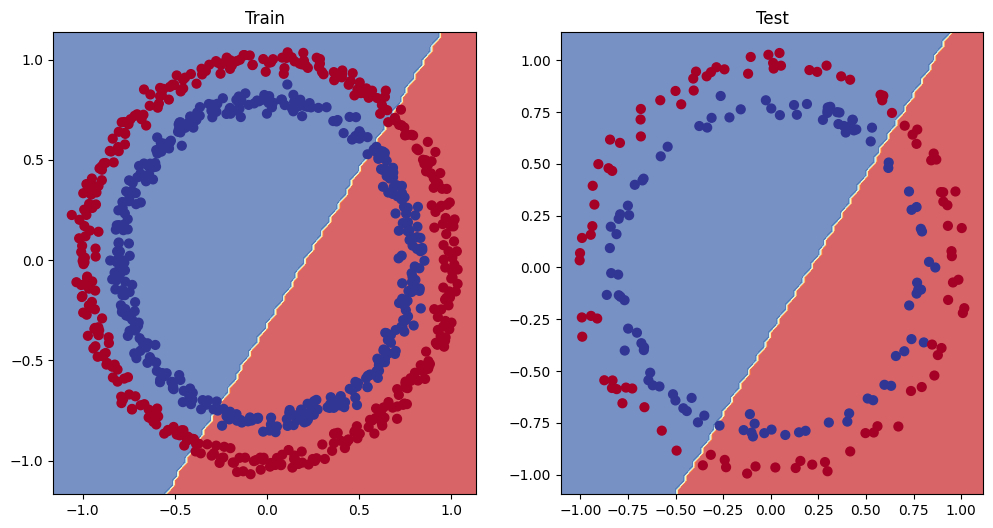

In [23]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [24]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10) # extra layer
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        
    def forward(self, x): # note: always make sure forward is spelt correctly!
        # Creating a model like this is the same as below, though below
        # generally benefits from speedups where possible.
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        # return z
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [25]:
# loss_fn = nn.BCELoss() # Requires sigmoid on input
loss_fn = nn.BCEWithLogitsLoss() # Does not require sigmoid on input
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [26]:
torch.manual_seed(42)

epochs = 1000 # Train for longer

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> predicition probabilities -> prediction labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Accuracy: 50.38% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Accuracy: 51.12% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%


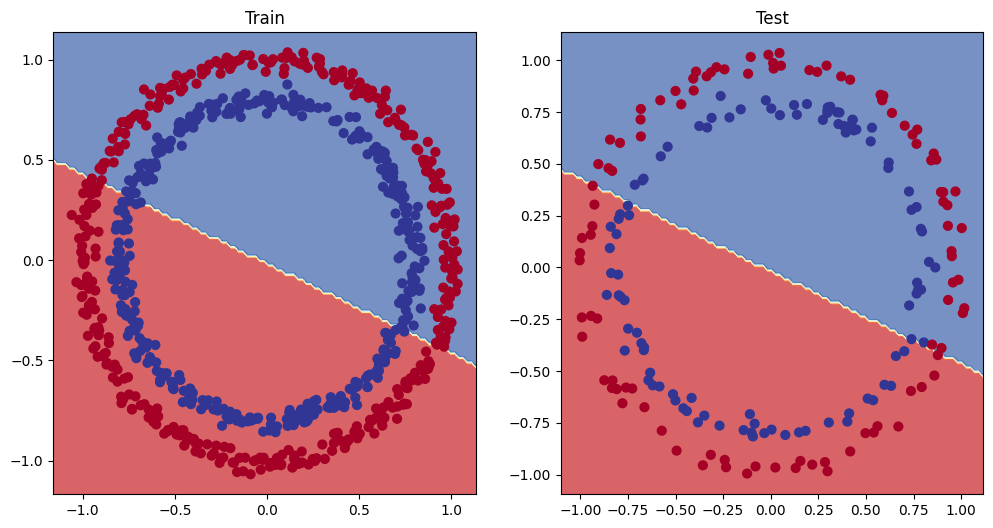

In [27]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### Missing piece: non-linearity

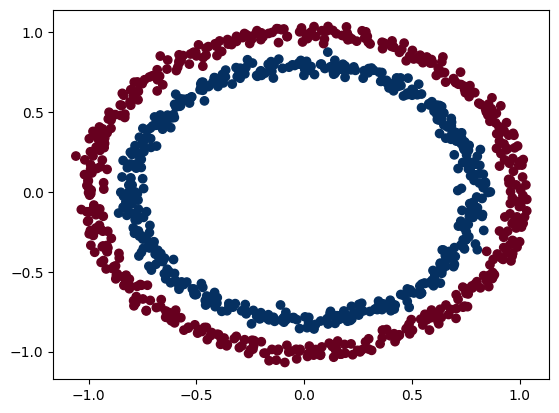

In [28]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=42,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

In [29]:
# Convert to tensors and split into train and test sets
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=42
)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [30]:
# Build model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model 
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [31]:
# Setup loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [32]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test Loss: 0.69102, Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test Loss: 0.68940, Test Accuracy: 55.00%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test Loss: 0.68723, Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test Loss: 0.68411, Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test Loss: 0.67941, Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test Loss: 0.67285, Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test Loss: 0.66322, Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test Loss: 0.64757, Test Accuracy: 67.50%
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test Loss: 0.62145, Test Accuracy: 79.00%


In [33]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.], device='mps:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

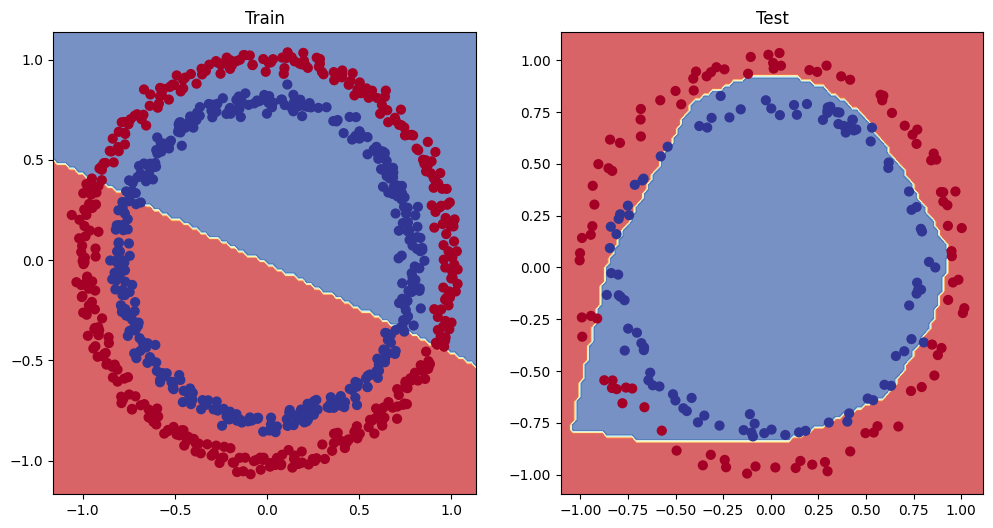

In [34]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

###  Putting things together by building a multi-class PyTorch model¶

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


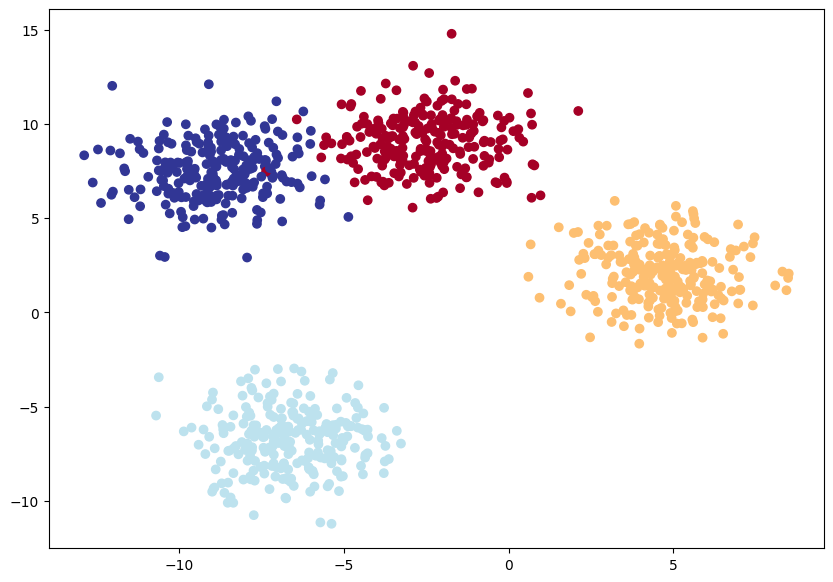

In [35]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [36]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [37]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), 
                            lr=0.1) # exercise: try changing the learning rate here and seeing what happens to the model's performance

In [38]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_4(X_blob_train.to(device))[:5]

tensor([[-1.2711, -0.6494, -1.4740, -0.7044],
        [ 0.2210, -1.5439,  0.0420,  1.1531],
        [ 2.8698,  0.9143,  3.3169,  1.4027],
        [ 1.9576,  0.3125,  2.2244,  1.1324],
        [ 0.5458, -1.2381,  0.4441,  1.1804]], device='mps:0',
       grad_fn=<SliceBackward0>)

In [39]:
# How many elements in a single prediction sample?
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES 

(torch.Size([4]), 4)

In [40]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1) 
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]], device='mps:0',
       grad_fn=<SliceBackward0>)
tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951]], device='mps:0',
       grad_fn=<SliceBackward0>)


In [41]:
# Sum the first sample output of the softmax activation function 
torch.sum(y_pred_probs[0])

tensor(1.0000, device='mps:0', grad_fn=<SumBackward0>)

In [42]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.1872, 0.2918, 0.1495, 0.3715], device='mps:0',
       grad_fn=<SelectBackward0>)
tensor(3, device='mps:0')


In [43]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train) 
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 1.04324, Acc: 65.50% | Test Loss: 0.57861, Test Acc: 95.50%
Epoch: 10 | Loss: 0.14398, Acc: 99.12% | Test Loss: 0.13037, Test Acc: 99.00%
Epoch: 20 | Loss: 0.08062, Acc: 99.12% | Test Loss: 0.07216, Test Acc: 99.50%
Epoch: 30 | Loss: 0.05924, Acc: 99.12% | Test Loss: 0.05133, Test Acc: 99.50%
Epoch: 40 | Loss: 0.04892, Acc: 99.00% | Test Loss: 0.04098, Test Acc: 99.50%
Epoch: 50 | Loss: 0.04295, Acc: 99.00% | Test Loss: 0.03486, Test Acc: 99.50%
Epoch: 60 | Loss: 0.03910, Acc: 99.00% | Test Loss: 0.03083, Test Acc: 99.50%
Epoch: 70 | Loss: 0.03643, Acc: 99.00% | Test Loss: 0.02799, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03448, Acc: 99.00% | Test Loss: 0.02587, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03300, Acc: 99.12% | Test Loss: 0.02423, Test Acc: 99.50%


In [44]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[  4.3378,  10.3539, -14.8948,  -9.7643],
        [  5.0142, -12.0371,   3.3860,  10.6700],
        [ -5.5885, -13.3448,  20.9895,  12.7711],
        [  1.8400,   7.5600,  -8.6016,  -6.9943],
        [  8.0727,   3.2906, -14.5998,  -3.6186],
        [  5.5844, -14.9522,   5.0168,  13.2891],
        [ -5.9739, -10.1913,  18.8656,   9.9179],
        [  7.0755,  -0.7601,  -9.5531,   0.1736],
        [ -5.5919, -18.5991,  25.5310,  17.5800],
        [  7.3143,   0.7197, -11.2018,  -1.2011]], device='mps:0')

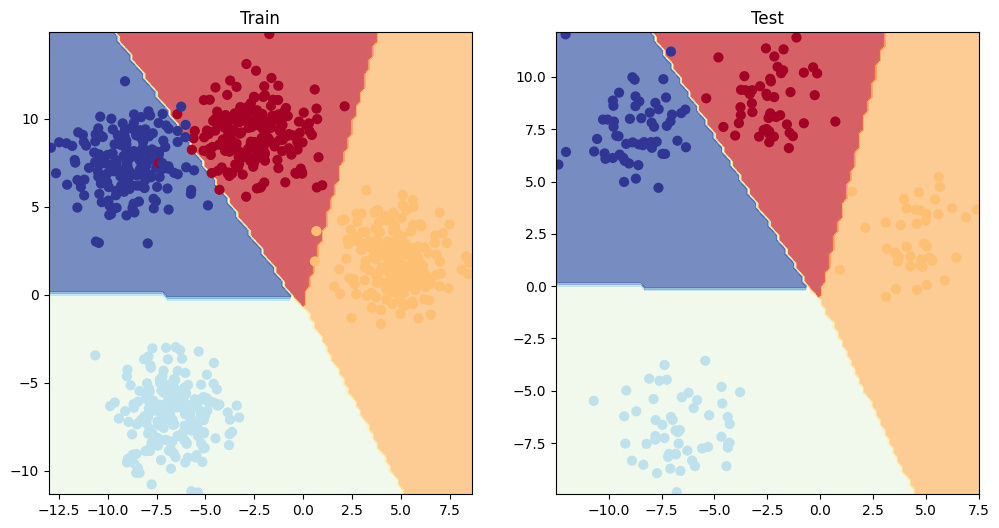

In [45]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)